<a href="https://colab.research.google.com/github/Juliaroch/Ironhack-final-project-Julia-Roch/blob/master/Training_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib 
import matplotlib.pyplot as plt
import random

In [3]:
import keras
import numpy
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [11]:
#Import the images from 11 artists I need for my training
images_dir = '/content/gdrive/My Drive/Final_project_data/resized_train_test'
data_artists = pd.read_csv('/content/gdrive/My Drive/Final_project_data/data_artists.csv')
artists_dirs = os.listdir(images_dir)
artists_top_name = data_artists['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))


Did not find --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Vincent_van_Gogh
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pablo_Picasso
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pierre-Auguste_Renoir
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Francisco_Goya
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Albrecht_Dürer
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Alfred_Sisley
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Marc_Chagall
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Edgar_Degas
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Rembrandt
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Titian
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Paul_Gauguin


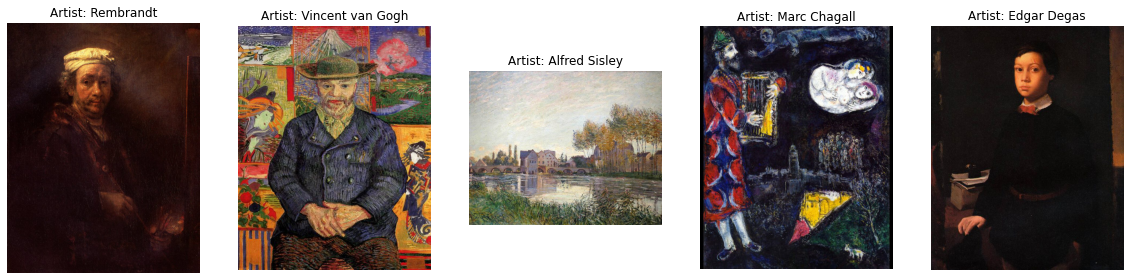

In [13]:
#See if images have been imported correctly 
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [15]:
#Train_test_split
batch_size = 16
train_input_shape = (128, 128, 3)
n_classes = artists_top_name.shape[0]

train_datagen=ImageDataGenerator(validation_split=0.1,rescale=1./255.,horizontal_flip=True,vertical_flip=True)
                                 
train_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="training",shuffle=True,classes=artists_top_name.tolist())
                                                   
valid_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="validation",shuffle=True,classes=artists_top_name.tolist())

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 2378 images belonging to 11 classes.
Found 260 images belonging to 11 classes.
Total number of batches = 148 and 16


In [16]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 1s 0us/step


In [0]:
X = base_model.output
X = Flatten()(X)

X = Dense(256, kernel_initializer='he_uniform')(X)
X = Dropout(0.25)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

#X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.25)(X)
#X = BatchNormalization()(X)
#X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [0]:
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [0]:
n_epoch = 16

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')

In [20]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr], use_multiprocessing=True, workers=16)

Epoch 1/16
148/148 [==============================] - 511s 3s/step - loss: 2.2652 - acc: 0.2295 - val_loss: 519.5219 - val_acc: 0.0859
Epoch 2/16
148/148 [==============================] - 464s 3s/step - loss: 2.1190 - acc: 0.2684 - val_loss: 345.7649 - val_acc: 0.1094
Epoch 3/16
148/148 [==============================] - 459s 3s/step - loss: 2.1396 - acc: 0.2519 - val_loss: 49.6051 - val_acc: 0.1641
Epoch 4/16
148/148 [==============================] - 460s 3s/step - loss: 2.0494 - acc: 0.2749 - val_loss: 2.4436 - val_acc: 0.1992
Epoch 5/16
148/148 [==============================] - 458s 3s/step - loss: 2.0836 - acc: 0.2547 - val_loss: 2761.2269 - val_acc: 0.0898
Epoch 6/16
148/148 [==============================] - 459s 3s/step - loss: 2.0007 - acc: 0.2887 - val_loss: 1.9361 - val_acc: 0.3359
Epoch 7/16
148/148 [==============================] - 466s 3s/step - loss: 1.9293 - acc: 0.3196 - val_loss: 2.5957 - val_acc: 0.2734
Epoch 8/16
148/148 [==============================] - 469s 3s

In [23]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

n_epoch = 16
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr, early_stop], use_multiprocessing=True, workers=16)

Epoch 1/16
148/148 [==============================] - 436s 3s/step - loss: 1.5402 - acc: 0.4505 - val_loss: 27.9334 - val_acc: 0.2734
Epoch 2/16
148/148 [==============================] - 414s 3s/step - loss: 1.5082 - acc: 0.4674 - val_loss: 7.6114 - val_acc: 0.3047
Epoch 3/16
148/148 [==============================] - 435s 3s/step - loss: 1.5356 - acc: 0.4526 - val_loss: 5.4273 - val_acc: 0.3906
Epoch 4/16
148/148 [==============================] - 424s 3s/step - loss: 1.4771 - acc: 0.4763 - val_loss: 1.6123 - val_acc: 0.4492
Epoch 5/16
148/148 [==============================] - 404s 3s/step - loss: 1.4645 - acc: 0.4877 - val_loss: 4.3012 - val_acc: 0.4062
Epoch 6/16
148/148 [==============================] - 406s 3s/step - loss: 1.4620 - acc: 0.4945 - val_loss: 7.7819 - val_acc: 0.2852
Epoch 7/16
148/148 [==============================] - 419s 3s/step - loss: 1.4422 - acc: 0.4924 - val_loss: 2.7543 - val_acc: 0.4336
Epoch 8/16
148/148 [==============================] - 432s 3s/step -